In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/fastai-solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/fastai-solaris/share/proj


In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops_black_white"
classification_labels = pd.read_csv(data_dir/"train_black_white.csv")
classification_labels["crop_filename"] = classification_labels["uuid"].apply(lambda x: f"{x}.png")
# damage_crops_test_folder = data_dir / "classification_crops_test"

In [3]:
classification_labels.head()

,Unnamed: 0,uuid,img_id,label,crop_filename
0,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [4]:
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
#         bce_dice = BCEDiceLoss()
#         lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss

def get_train_valid_ids(classification_labels_df, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df.img_id.unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df.img_id.isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df.img_id.isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids

In [5]:
def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#


In [7]:
train_ids, valid_ids = get_train_valid_ids(classification_labels)
size=64
bs=32
partial_data_frac=0.2
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
#         .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss();
learn.to_fp16();

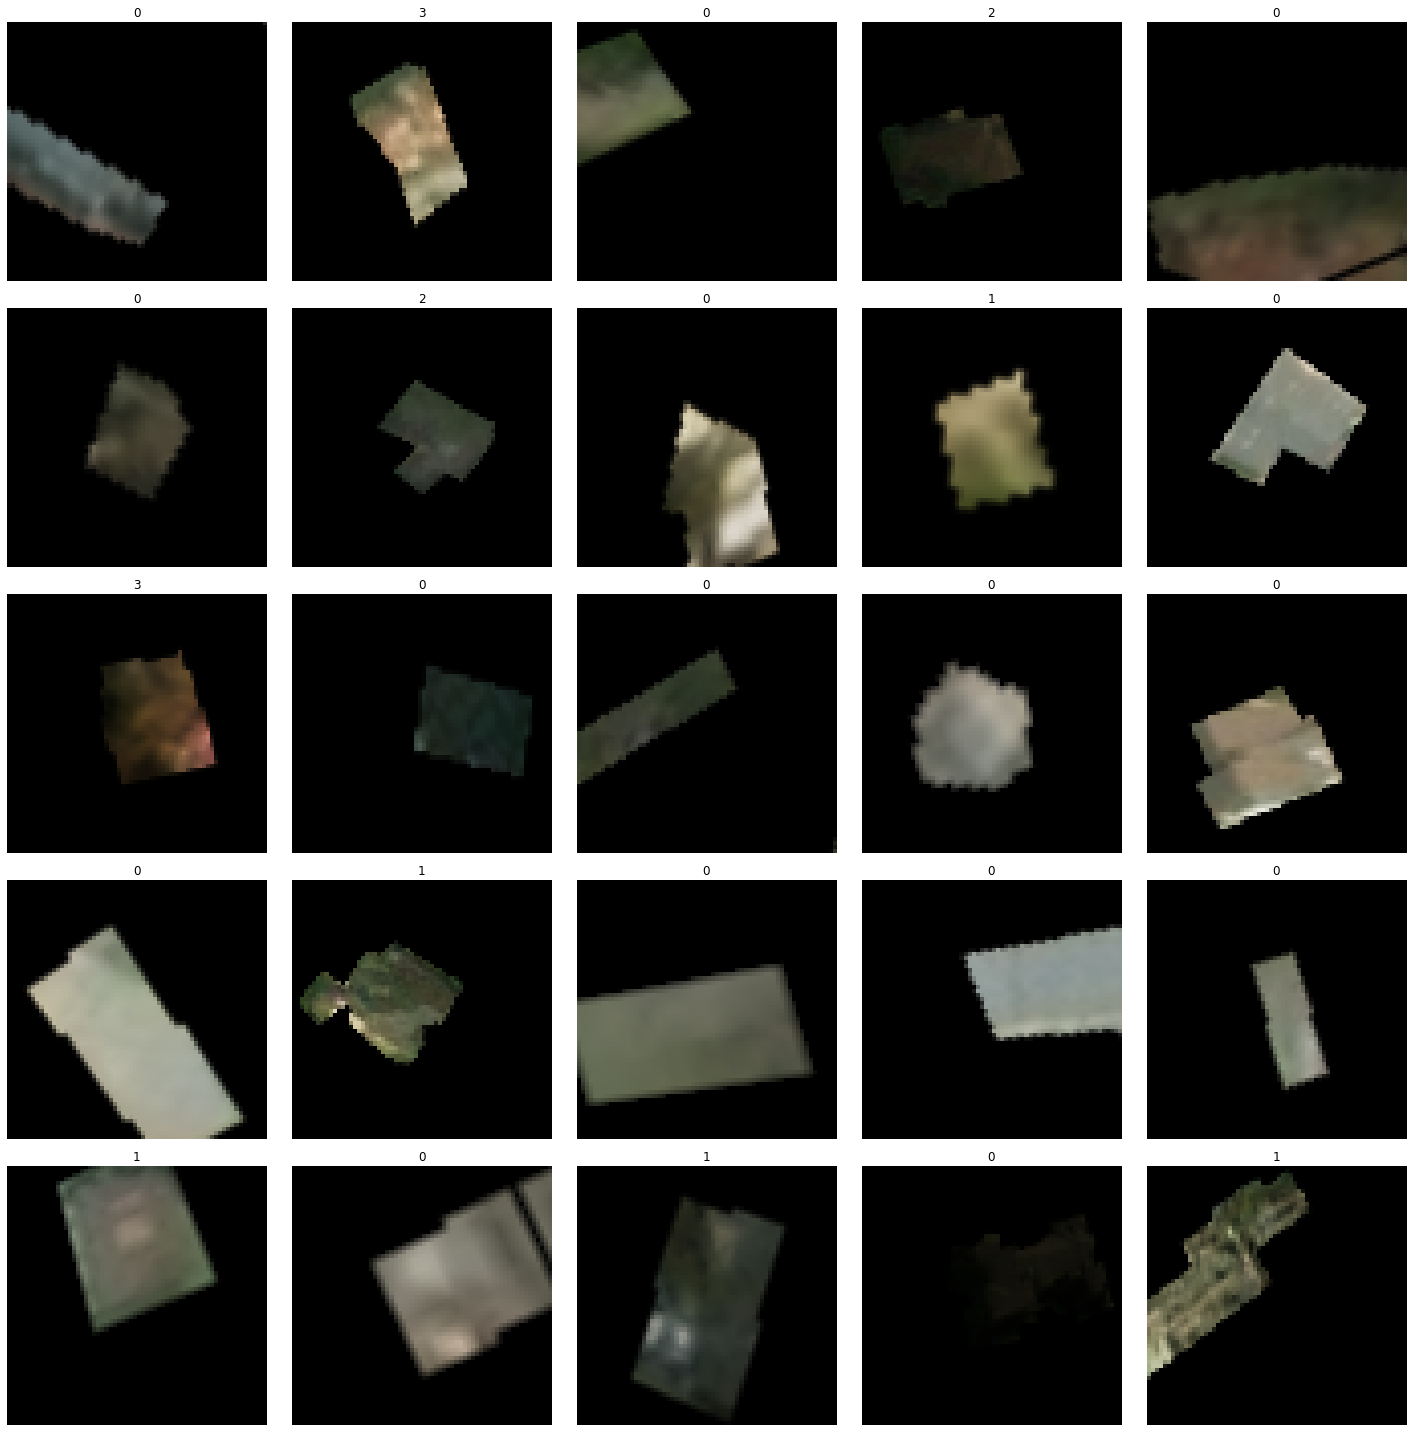

In [7]:
data.show_batch()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


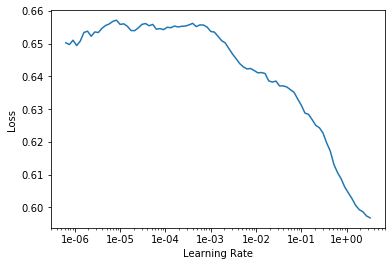

In [8]:
learn.lr_find()
learn.recorder.plot();

In [9]:
learn.fit_one_cycle(2, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.511109,0.496395,0.767711,0.767711,14:22
1,0.510639,0.496395,0.767711,0.767711,02:48


In [10]:
learn.fit_one_cycle(2, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.504193,0.496395,0.767711,0.766944,02:47
1,0.507944,0.496395,0.767711,0.765678,02:50


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


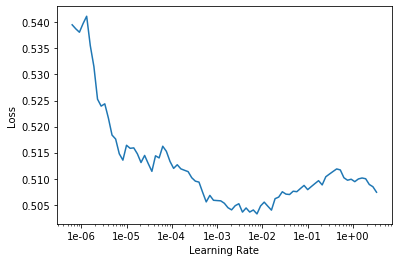

In [11]:
learn.lr_find()
learn.recorder.plot();

In [12]:
learn.loss_func = CombinedLoss(alpha=0.75, gamma=4);
learn.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.064068,0.060250,0.767711,0.765263,02:49
1,0.063677,0.060250,0.767711,0.766088,02:47
2,0.063708,0.060250,0.767711,0.765125,02:48


In [16]:
learn = cnn_learner(data, models.densenet121 , metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.75, gamma=4);
learn.to_fp16();

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/wwymak/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 12.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


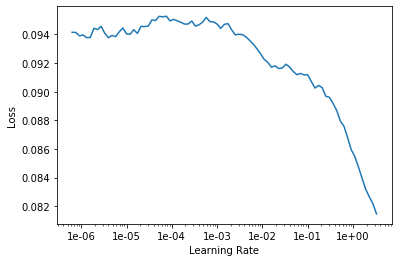

In [17]:
learn.lr_find()
learn.recorder.plot();

In [ ]:
learn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,f1,time
